# Imports

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import CatBoost as cb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec 
import nltk
import re
from nltk.stem import WordNetLemmatizer
import statistics

In [2]:
train = pd.read_csv("train_F3WbcTw.csv")
test = pd.read_csv("test_tOlRoBf.csv")
sample = pd.read_csv("sample_submission_i5xnIZD.csv")

In [3]:
train_df = train.copy()
test_df = test.copy()

In [4]:
train_df.head()

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


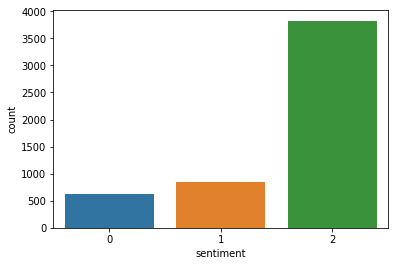

In [5]:
sns.countplot(train_df.sentiment)

# Text preprocessing

In [6]:
def cleaning(s):
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    return s

In [7]:
wordnet_lemmatizer = WordNetLemmatizer()

In [8]:
train_df['text'] = train_df['text'].apply(wordnet_lemmatizer.lemmatize)

In [10]:
test_df['text'] = test_df['text'].apply(wordnet_lemmatizer.lemmatize)

In [105]:
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,7),max_df=0.6,use_idf=False)

In [106]:
tfidf.fit(train_df.text.append(test_df.text))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.6, max_features=None, min_df=1,
        ngram_range=(1, 7), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=False,
        vocabulary=None)

In [107]:
train_features = tfidf.transform(train_df.text)

In [108]:
le  = LabelEncoder()

In [109]:
le.fit(train_df.drug.append(test_df.drug))

LabelEncoder()

In [110]:
train_m  = le.transform(train_df.drug)

In [111]:
train_m = train_m.reshape(5279,1)

In [112]:
newfeatures = hstack((train_features,train_m)).tocsr()

In [113]:
x,y = newfeatures,train_df.sentiment

# Validation SetUp

In [114]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=.20, random_state=0)
for train_index, test_index in sss.split(x, y):
    x_train,x_test,y_train,y_test = x[train_index],x[test_index],y[train_index],y[test_index]

# Modelling 

In [115]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [116]:
lg = LGBMClassifier(n_estimators=10000,metric="custom",max_depth=4,num_leaves=30,min_split_gain=0,min_data_in_leaf=130,learning_rate=0.05,)

In [117]:
lg.fit(x_train,y_train,eval_set=(x_test,y_test),eval_metric=evaluate_macroF1_lgb,early_stopping_rounds=1000)

c:\users\anubh\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[1]	valid_0's macroF1: 0.280066
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's macroF1: 0.280066
[3]	valid_0's macroF1: 0.280066
[4]	valid_0's macroF1: 0.280066
[5]	valid_0's macroF1: 0.280066
[6]	valid_0's macroF1: 0.280066
[7]	valid_0's macroF1: 0.280066
[8]	valid_0's macroF1: 0.280066
[9]	valid_0's macroF1: 0.280066
[10]	valid_0's macroF1: 0.280066
[11]	valid_0's macroF1: 0.280066
[12]	valid_0's macroF1: 0.280066
[13]	valid_0's macroF1: 0.280066
[14]	valid_0's macroF1: 0.280066
[15]	valid_0's macroF1: 0.280066
[16]	valid_0's macroF1: 0.280066
[17]	valid_0's macroF1: 0.280066
[18]	valid_0's macroF1: 0.280066
[19]	valid_0's macroF1: 0.280066
[20]	valid_0's macroF1: 0.280066
[21]	valid_0's macroF1: 0.280066
[22]	valid_0's macroF1: 0.280066
[23]	valid_0's macroF1: 0.280066
[24]	valid_0's macroF1: 0.280066
[25]	valid_0's macroF1: 0.280066
[26]	valid_0's macroF1: 0.280066
[27]	valid_0's macroF1: 0.280066
[28]	valid_0's macroF1: 0.280066
[29]	valid_0's macroF

[254]	valid_0's macroF1: 0.342745
[255]	valid_0's macroF1: 0.341782
[256]	valid_0's macroF1: 0.341782
[257]	valid_0's macroF1: 0.341782
[258]	valid_0's macroF1: 0.341304
[259]	valid_0's macroF1: 0.341304
[260]	valid_0's macroF1: 0.341304
[261]	valid_0's macroF1: 0.341304
[262]	valid_0's macroF1: 0.341782
[263]	valid_0's macroF1: 0.341782
[264]	valid_0's macroF1: 0.341304
[265]	valid_0's macroF1: 0.341782
[266]	valid_0's macroF1: 0.341782
[267]	valid_0's macroF1: 0.341782
[268]	valid_0's macroF1: 0.340829
[269]	valid_0's macroF1: 0.340829
[270]	valid_0's macroF1: 0.340829
[271]	valid_0's macroF1: 0.340829
[272]	valid_0's macroF1: 0.340829
[273]	valid_0's macroF1: 0.340829
[274]	valid_0's macroF1: 0.340829
[275]	valid_0's macroF1: 0.340829
[276]	valid_0's macroF1: 0.340829
[277]	valid_0's macroF1: 0.340829
[278]	valid_0's macroF1: 0.340829
[279]	valid_0's macroF1: 0.340356
[280]	valid_0's macroF1: 0.340356
[281]	valid_0's macroF1: 0.340356
[282]	valid_0's macroF1: 0.340829
[283]	valid_0'

[508]	valid_0's macroF1: 0.357933
[509]	valid_0's macroF1: 0.357933
[510]	valid_0's macroF1: 0.357933
[511]	valid_0's macroF1: 0.358071
[512]	valid_0's macroF1: 0.358071
[513]	valid_0's macroF1: 0.358071
[514]	valid_0's macroF1: 0.363057
[515]	valid_0's macroF1: 0.365978
[516]	valid_0's macroF1: 0.36292
[517]	valid_0's macroF1: 0.36292
[518]	valid_0's macroF1: 0.36292
[519]	valid_0's macroF1: 0.36292
[520]	valid_0's macroF1: 0.36292
[521]	valid_0's macroF1: 0.36292
[522]	valid_0's macroF1: 0.363057
[523]	valid_0's macroF1: 0.363057
[524]	valid_0's macroF1: 0.362406
[525]	valid_0's macroF1: 0.36292
[526]	valid_0's macroF1: 0.36292
[527]	valid_0's macroF1: 0.362554
[528]	valid_0's macroF1: 0.362406
[529]	valid_0's macroF1: 0.362541
[530]	valid_0's macroF1: 0.363057
[531]	valid_0's macroF1: 0.363057
[532]	valid_0's macroF1: 0.363057
[533]	valid_0's macroF1: 0.363057
[534]	valid_0's macroF1: 0.363057
[535]	valid_0's macroF1: 0.362541
[536]	valid_0's macroF1: 0.363057
[537]	valid_0's macroF

[760]	valid_0's macroF1: 0.37749
[761]	valid_0's macroF1: 0.37749
[762]	valid_0's macroF1: 0.37749
[763]	valid_0's macroF1: 0.37749
[764]	valid_0's macroF1: 0.37749
[765]	valid_0's macroF1: 0.37749
[766]	valid_0's macroF1: 0.37749
[767]	valid_0's macroF1: 0.37749
[768]	valid_0's macroF1: 0.37749
[769]	valid_0's macroF1: 0.37749
[770]	valid_0's macroF1: 0.37749
[771]	valid_0's macroF1: 0.37749
[772]	valid_0's macroF1: 0.37749
[773]	valid_0's macroF1: 0.37749
[774]	valid_0's macroF1: 0.374746
[775]	valid_0's macroF1: 0.374746
[776]	valid_0's macroF1: 0.374746
[777]	valid_0's macroF1: 0.374746
[778]	valid_0's macroF1: 0.374746
[779]	valid_0's macroF1: 0.374746
[780]	valid_0's macroF1: 0.374746
[781]	valid_0's macroF1: 0.374746
[782]	valid_0's macroF1: 0.374746
[783]	valid_0's macroF1: 0.374746
[784]	valid_0's macroF1: 0.374746
[785]	valid_0's macroF1: 0.374746
[786]	valid_0's macroF1: 0.374746
[787]	valid_0's macroF1: 0.374746
[788]	valid_0's macroF1: 0.374708
[789]	valid_0's macroF1: 0.3

[1006]	valid_0's macroF1: 0.40229
[1007]	valid_0's macroF1: 0.409078
[1008]	valid_0's macroF1: 0.409078
[1009]	valid_0's macroF1: 0.409078
[1010]	valid_0's macroF1: 0.41014
[1011]	valid_0's macroF1: 0.41014
[1012]	valid_0's macroF1: 0.409607
[1013]	valid_0's macroF1: 0.41014
[1014]	valid_0's macroF1: 0.412748
[1015]	valid_0's macroF1: 0.412748
[1016]	valid_0's macroF1: 0.412748
[1017]	valid_0's macroF1: 0.416347
[1018]	valid_0's macroF1: 0.416347
[1019]	valid_0's macroF1: 0.416347
[1020]	valid_0's macroF1: 0.418935
[1021]	valid_0's macroF1: 0.416347
[1022]	valid_0's macroF1: 0.416347
[1023]	valid_0's macroF1: 0.416347
[1024]	valid_0's macroF1: 0.416347
[1025]	valid_0's macroF1: 0.416347
[1026]	valid_0's macroF1: 0.416347
[1027]	valid_0's macroF1: 0.416347
[1028]	valid_0's macroF1: 0.416347
[1029]	valid_0's macroF1: 0.416347
[1030]	valid_0's macroF1: 0.416347
[1031]	valid_0's macroF1: 0.416347
[1032]	valid_0's macroF1: 0.416904
[1033]	valid_0's macroF1: 0.416904
[1034]	valid_0's macroF1

[1254]	valid_0's macroF1: 0.416235
[1255]	valid_0's macroF1: 0.416235
[1256]	valid_0's macroF1: 0.415708
[1257]	valid_0's macroF1: 0.415708
[1258]	valid_0's macroF1: 0.415708
[1259]	valid_0's macroF1: 0.415708
[1260]	valid_0's macroF1: 0.416316
[1261]	valid_0's macroF1: 0.415708
[1262]	valid_0's macroF1: 0.416316
[1263]	valid_0's macroF1: 0.416097
[1264]	valid_0's macroF1: 0.413538
[1265]	valid_0's macroF1: 0.413538
[1266]	valid_0's macroF1: 0.413538
[1267]	valid_0's macroF1: 0.413538
[1268]	valid_0's macroF1: 0.413538
[1269]	valid_0's macroF1: 0.416097
[1270]	valid_0's macroF1: 0.416097
[1271]	valid_0's macroF1: 0.416097
[1272]	valid_0's macroF1: 0.416623
[1273]	valid_0's macroF1: 0.416097
[1274]	valid_0's macroF1: 0.416097
[1275]	valid_0's macroF1: 0.413538
[1276]	valid_0's macroF1: 0.414064
[1277]	valid_0's macroF1: 0.414064
[1278]	valid_0's macroF1: 0.414064
[1279]	valid_0's macroF1: 0.414064
[1280]	valid_0's macroF1: 0.416623
[1281]	valid_0's macroF1: 0.416623
[1282]	valid_0's mac

[1499]	valid_0's macroF1: 0.422054
[1500]	valid_0's macroF1: 0.424487
[1501]	valid_0's macroF1: 0.426903
[1502]	valid_0's macroF1: 0.428363
[1503]	valid_0's macroF1: 0.428363
[1504]	valid_0's macroF1: 0.428363
[1505]	valid_0's macroF1: 0.427831
[1506]	valid_0's macroF1: 0.423349
[1507]	valid_0's macroF1: 0.424869
[1508]	valid_0's macroF1: 0.427831
[1509]	valid_0's macroF1: 0.430247
[1510]	valid_0's macroF1: 0.430247
[1511]	valid_0's macroF1: 0.426389
[1512]	valid_0's macroF1: 0.423856
[1513]	valid_0's macroF1: 0.423856
[1514]	valid_0's macroF1: 0.426271
[1515]	valid_0's macroF1: 0.426271
[1516]	valid_0's macroF1: 0.428669
[1517]	valid_0's macroF1: 0.432645
[1518]	valid_0's macroF1: 0.428669
[1519]	valid_0's macroF1: 0.428669
[1520]	valid_0's macroF1: 0.428669
[1521]	valid_0's macroF1: 0.426271
[1522]	valid_0's macroF1: 0.428669
[1523]	valid_0's macroF1: 0.428669
[1524]	valid_0's macroF1: 0.428669
[1525]	valid_0's macroF1: 0.426271
[1526]	valid_0's macroF1: 0.426781
[1527]	valid_0's mac

[1740]	valid_0's macroF1: 0.426982
[1741]	valid_0's macroF1: 0.426982
[1742]	valid_0's macroF1: 0.426982
[1743]	valid_0's macroF1: 0.426982
[1744]	valid_0's macroF1: 0.426982
[1745]	valid_0's macroF1: 0.426982
[1746]	valid_0's macroF1: 0.426982
[1747]	valid_0's macroF1: 0.426982
[1748]	valid_0's macroF1: 0.426982
[1749]	valid_0's macroF1: 0.426982
[1750]	valid_0's macroF1: 0.426982
[1751]	valid_0's macroF1: 0.426982
[1752]	valid_0's macroF1: 0.426982
[1753]	valid_0's macroF1: 0.426982
[1754]	valid_0's macroF1: 0.426982
[1755]	valid_0's macroF1: 0.426982
[1756]	valid_0's macroF1: 0.426982
[1757]	valid_0's macroF1: 0.427605
[1758]	valid_0's macroF1: 0.427605
[1759]	valid_0's macroF1: 0.427605
[1760]	valid_0's macroF1: 0.427605
[1761]	valid_0's macroF1: 0.430031
[1762]	valid_0's macroF1: 0.430031
[1763]	valid_0's macroF1: 0.430031
[1764]	valid_0's macroF1: 0.430031
[1765]	valid_0's macroF1: 0.430031
[1766]	valid_0's macroF1: 0.430031
[1767]	valid_0's macroF1: 0.430031
[1768]	valid_0's mac

[1976]	valid_0's macroF1: 0.431936
[1977]	valid_0's macroF1: 0.431936
[1978]	valid_0's macroF1: 0.431936
[1979]	valid_0's macroF1: 0.431936
[1980]	valid_0's macroF1: 0.431936
[1981]	valid_0's macroF1: 0.431936
[1982]	valid_0's macroF1: 0.431936
[1983]	valid_0's macroF1: 0.431936
[1984]	valid_0's macroF1: 0.431317
[1985]	valid_0's macroF1: 0.431936
[1986]	valid_0's macroF1: 0.431936
[1987]	valid_0's macroF1: 0.431936
[1988]	valid_0's macroF1: 0.431936
[1989]	valid_0's macroF1: 0.431936
[1990]	valid_0's macroF1: 0.431936
[1991]	valid_0's macroF1: 0.431317
[1992]	valid_0's macroF1: 0.431936
[1993]	valid_0's macroF1: 0.431936
[1994]	valid_0's macroF1: 0.431936
[1995]	valid_0's macroF1: 0.431936
[1996]	valid_0's macroF1: 0.430701
[1997]	valid_0's macroF1: 0.431273
[1998]	valid_0's macroF1: 0.431889
[1999]	valid_0's macroF1: 0.431317
[2000]	valid_0's macroF1: 0.431317
[2001]	valid_0's macroF1: 0.431317
[2002]	valid_0's macroF1: 0.431317
[2003]	valid_0's macroF1: 0.431317
[2004]	valid_0's mac

[2222]	valid_0's macroF1: 0.443622
[2223]	valid_0's macroF1: 0.439826
[2224]	valid_0's macroF1: 0.439826
[2225]	valid_0's macroF1: 0.443406
[2226]	valid_0's macroF1: 0.443406
[2227]	valid_0's macroF1: 0.443406
[2228]	valid_0's macroF1: 0.443406
[2229]	valid_0's macroF1: 0.443406
[2230]	valid_0's macroF1: 0.443406
[2231]	valid_0's macroF1: 0.443406
[2232]	valid_0's macroF1: 0.443406
[2233]	valid_0's macroF1: 0.443622
[2234]	valid_0's macroF1: 0.443622
[2235]	valid_0's macroF1: 0.443406
[2236]	valid_0's macroF1: 0.443194
[2237]	valid_0's macroF1: 0.443406
[2238]	valid_0's macroF1: 0.443406
[2239]	valid_0's macroF1: 0.43963
[2240]	valid_0's macroF1: 0.443406
[2241]	valid_0's macroF1: 0.443406
[2242]	valid_0's macroF1: 0.443622
[2243]	valid_0's macroF1: 0.443622
[2244]	valid_0's macroF1: 0.443622
[2245]	valid_0's macroF1: 0.443406
[2246]	valid_0's macroF1: 0.443622
[2247]	valid_0's macroF1: 0.443622
[2248]	valid_0's macroF1: 0.443406
[2249]	valid_0's macroF1: 0.443406
[2250]	valid_0's macr

[2463]	valid_0's macroF1: 0.441098
[2464]	valid_0's macroF1: 0.441098
[2465]	valid_0's macroF1: 0.441098
[2466]	valid_0's macroF1: 0.444813
[2467]	valid_0's macroF1: 0.444813
[2468]	valid_0's macroF1: 0.445432
[2469]	valid_0's macroF1: 0.445432
[2470]	valid_0's macroF1: 0.445432
[2471]	valid_0's macroF1: 0.445432
[2472]	valid_0's macroF1: 0.445432
[2473]	valid_0's macroF1: 0.445432
[2474]	valid_0's macroF1: 0.449106
[2475]	valid_0's macroF1: 0.445432
[2476]	valid_0's macroF1: 0.445432
[2477]	valid_0's macroF1: 0.444813
[2478]	valid_0's macroF1: 0.444813
[2479]	valid_0's macroF1: 0.444813
[2480]	valid_0's macroF1: 0.444813
[2481]	valid_0's macroF1: 0.444813
[2482]	valid_0's macroF1: 0.444196
[2483]	valid_0's macroF1: 0.444813
[2484]	valid_0's macroF1: 0.444813
[2485]	valid_0's macroF1: 0.444813
[2486]	valid_0's macroF1: 0.444196
[2487]	valid_0's macroF1: 0.444196
[2488]	valid_0's macroF1: 0.444196
[2489]	valid_0's macroF1: 0.444813
[2490]	valid_0's macroF1: 0.444588
[2491]	valid_0's mac

[2705]	valid_0's macroF1: 0.443594
[2706]	valid_0's macroF1: 0.442367
[2707]	valid_0's macroF1: 0.442974
[2708]	valid_0's macroF1: 0.442367
[2709]	valid_0's macroF1: 0.444612
[2710]	valid_0's macroF1: 0.442974
[2711]	valid_0's macroF1: 0.445226
[2712]	valid_0's macroF1: 0.445226
[2713]	valid_0's macroF1: 0.442974
[2714]	valid_0's macroF1: 0.442974
[2715]	valid_0's macroF1: 0.442974
[2716]	valid_0's macroF1: 0.442974
[2717]	valid_0's macroF1: 0.442974
[2718]	valid_0's macroF1: 0.442974
[2719]	valid_0's macroF1: 0.443195
[2720]	valid_0's macroF1: 0.442974
[2721]	valid_0's macroF1: 0.445226
[2722]	valid_0's macroF1: 0.445226
[2723]	valid_0's macroF1: 0.445226
[2724]	valid_0's macroF1: 0.445446
[2725]	valid_0's macroF1: 0.444832
[2726]	valid_0's macroF1: 0.444832
[2727]	valid_0's macroF1: 0.444832
[2728]	valid_0's macroF1: 0.444832
[2729]	valid_0's macroF1: 0.444612
[2730]	valid_0's macroF1: 0.445446
[2731]	valid_0's macroF1: 0.445226
[2732]	valid_0's macroF1: 0.445226
[2733]	valid_0's mac

[2949]	valid_0's macroF1: 0.446363
[2950]	valid_0's macroF1: 0.446363
[2951]	valid_0's macroF1: 0.446363
[2952]	valid_0's macroF1: 0.446363
[2953]	valid_0's macroF1: 0.446363
[2954]	valid_0's macroF1: 0.446363
[2955]	valid_0's macroF1: 0.446363
[2956]	valid_0's macroF1: 0.446363
[2957]	valid_0's macroF1: 0.446363
[2958]	valid_0's macroF1: 0.446363
[2959]	valid_0's macroF1: 0.446363
[2960]	valid_0's macroF1: 0.446363
[2961]	valid_0's macroF1: 0.445743
[2962]	valid_0's macroF1: 0.445743
[2963]	valid_0's macroF1: 0.445527
[2964]	valid_0's macroF1: 0.445527
[2965]	valid_0's macroF1: 0.445527
[2966]	valid_0's macroF1: 0.445527
[2967]	valid_0's macroF1: 0.446363
[2968]	valid_0's macroF1: 0.446363
[2969]	valid_0's macroF1: 0.446363
[2970]	valid_0's macroF1: 0.445743
[2971]	valid_0's macroF1: 0.445743
[2972]	valid_0's macroF1: 0.445743
[2973]	valid_0's macroF1: 0.445527
[2974]	valid_0's macroF1: 0.445527
[2975]	valid_0's macroF1: 0.445527
[2976]	valid_0's macroF1: 0.445527
[2977]	valid_0's mac

[3192]	valid_0's macroF1: 0.443421
[3193]	valid_0's macroF1: 0.443421
[3194]	valid_0's macroF1: 0.443421
[3195]	valid_0's macroF1: 0.443421
[3196]	valid_0's macroF1: 0.443421
[3197]	valid_0's macroF1: 0.444043
[3198]	valid_0's macroF1: 0.444043
[3199]	valid_0's macroF1: 0.444043
[3200]	valid_0's macroF1: 0.444043
[3201]	valid_0's macroF1: 0.444043
[3202]	valid_0's macroF1: 0.444043
[3203]	valid_0's macroF1: 0.444043
[3204]	valid_0's macroF1: 0.444043
[3205]	valid_0's macroF1: 0.444043
[3206]	valid_0's macroF1: 0.444043
[3207]	valid_0's macroF1: 0.444043
[3208]	valid_0's macroF1: 0.444043
[3209]	valid_0's macroF1: 0.444043
[3210]	valid_0's macroF1: 0.444634
[3211]	valid_0's macroF1: 0.444634
[3212]	valid_0's macroF1: 0.444634
[3213]	valid_0's macroF1: 0.444634
[3214]	valid_0's macroF1: 0.444043
[3215]	valid_0's macroF1: 0.444043
[3216]	valid_0's macroF1: 0.443456
[3217]	valid_0's macroF1: 0.444043
[3218]	valid_0's macroF1: 0.444043
[3219]	valid_0's macroF1: 0.444043
[3220]	valid_0's mac

[3431]	valid_0's macroF1: 0.45042
[3432]	valid_0's macroF1: 0.451045
[3433]	valid_0's macroF1: 0.453261
[3434]	valid_0's macroF1: 0.453888
[3435]	valid_0's macroF1: 0.453264
[3436]	valid_0's macroF1: 0.453264
[3437]	valid_0's macroF1: 0.453264
[3438]	valid_0's macroF1: 0.453264
[3439]	valid_0's macroF1: 0.453264
[3440]	valid_0's macroF1: 0.453264
[3441]	valid_0's macroF1: 0.453264
[3442]	valid_0's macroF1: 0.453264
[3443]	valid_0's macroF1: 0.453264
[3444]	valid_0's macroF1: 0.449783
[3445]	valid_0's macroF1: 0.449783
[3446]	valid_0's macroF1: 0.449783
[3447]	valid_0's macroF1: 0.449783
[3448]	valid_0's macroF1: 0.449155
[3449]	valid_0's macroF1: 0.449783
[3450]	valid_0's macroF1: 0.449783
[3451]	valid_0's macroF1: 0.449783
[3452]	valid_0's macroF1: 0.449783
[3453]	valid_0's macroF1: 0.449155
[3454]	valid_0's macroF1: 0.44855
[3455]	valid_0's macroF1: 0.44855
[3456]	valid_0's macroF1: 0.449179
[3457]	valid_0's macroF1: 0.449179
[3458]	valid_0's macroF1: 0.449179
[3459]	valid_0's macroF

[3679]	valid_0's macroF1: 0.447474
[3680]	valid_0's macroF1: 0.447288
[3681]	valid_0's macroF1: 0.447288
[3682]	valid_0's macroF1: 0.447288
[3683]	valid_0's macroF1: 0.447288
[3684]	valid_0's macroF1: 0.447288
[3685]	valid_0's macroF1: 0.447288
[3686]	valid_0's macroF1: 0.447288
[3687]	valid_0's macroF1: 0.447329
[3688]	valid_0's macroF1: 0.447329
[3689]	valid_0's macroF1: 0.447329
[3690]	valid_0's macroF1: 0.447916
[3691]	valid_0's macroF1: 0.447916
[3692]	valid_0's macroF1: 0.448102
[3693]	valid_0's macroF1: 0.448102
[3694]	valid_0's macroF1: 0.448102
[3695]	valid_0's macroF1: 0.447512
[3696]	valid_0's macroF1: 0.447288
[3697]	valid_0's macroF1: 0.447288
[3698]	valid_0's macroF1: 0.447879
[3699]	valid_0's macroF1: 0.447879
[3700]	valid_0's macroF1: 0.446702
[3701]	valid_0's macroF1: 0.446702
[3702]	valid_0's macroF1: 0.446702
[3703]	valid_0's macroF1: 0.447512
[3704]	valid_0's macroF1: 0.447512
[3705]	valid_0's macroF1: 0.448102
[3706]	valid_0's macroF1: 0.447879
[3707]	valid_0's mac

[3922]	valid_0's macroF1: 0.444339
[3923]	valid_0's macroF1: 0.444339
[3924]	valid_0's macroF1: 0.444339
[3925]	valid_0's macroF1: 0.444339
[3926]	valid_0's macroF1: 0.444339
[3927]	valid_0's macroF1: 0.444339
[3928]	valid_0's macroF1: 0.444339
[3929]	valid_0's macroF1: 0.444339
[3930]	valid_0's macroF1: 0.444339
[3931]	valid_0's macroF1: 0.444339
[3932]	valid_0's macroF1: 0.444339
[3933]	valid_0's macroF1: 0.444339
[3934]	valid_0's macroF1: 0.444339
[3935]	valid_0's macroF1: 0.444339
[3936]	valid_0's macroF1: 0.444339
[3937]	valid_0's macroF1: 0.444339
[3938]	valid_0's macroF1: 0.444339
[3939]	valid_0's macroF1: 0.444339
[3940]	valid_0's macroF1: 0.444339
[3941]	valid_0's macroF1: 0.444339
[3942]	valid_0's macroF1: 0.444339
[3943]	valid_0's macroF1: 0.444339
[3944]	valid_0's macroF1: 0.444339
[3945]	valid_0's macroF1: 0.444339
[3946]	valid_0's macroF1: 0.444339
[3947]	valid_0's macroF1: 0.444339
[3948]	valid_0's macroF1: 0.444339
[3949]	valid_0's macroF1: 0.444339
[3950]	valid_0's mac

[4166]	valid_0's macroF1: 0.441453
[4167]	valid_0's macroF1: 0.441453
[4168]	valid_0's macroF1: 0.441453
[4169]	valid_0's macroF1: 0.441453
[4170]	valid_0's macroF1: 0.441453
[4171]	valid_0's macroF1: 0.441453
[4172]	valid_0's macroF1: 0.441453
[4173]	valid_0's macroF1: 0.441453
[4174]	valid_0's macroF1: 0.441453
[4175]	valid_0's macroF1: 0.441453
[4176]	valid_0's macroF1: 0.441453
[4177]	valid_0's macroF1: 0.441453
[4178]	valid_0's macroF1: 0.441453
[4179]	valid_0's macroF1: 0.443631
[4180]	valid_0's macroF1: 0.443631
[4181]	valid_0's macroF1: 0.443631
[4182]	valid_0's macroF1: 0.441453
[4183]	valid_0's macroF1: 0.441453
[4184]	valid_0's macroF1: 0.441453
[4185]	valid_0's macroF1: 0.441453
[4186]	valid_0's macroF1: 0.441453
[4187]	valid_0's macroF1: 0.441453
[4188]	valid_0's macroF1: 0.441453
[4189]	valid_0's macroF1: 0.441453
[4190]	valid_0's macroF1: 0.441453
[4191]	valid_0's macroF1: 0.443631
[4192]	valid_0's macroF1: 0.443631
[4193]	valid_0's macroF1: 0.443631
[4194]	valid_0's mac

[4410]	valid_0's macroF1: 0.446108
[4411]	valid_0's macroF1: 0.446108
[4412]	valid_0's macroF1: 0.446108
[4413]	valid_0's macroF1: 0.446108
[4414]	valid_0's macroF1: 0.44554
[4415]	valid_0's macroF1: 0.44554
[4416]	valid_0's macroF1: 0.44554
[4417]	valid_0's macroF1: 0.44554
[4418]	valid_0's macroF1: 0.444911
[4419]	valid_0's macroF1: 0.444911
[4420]	valid_0's macroF1: 0.44554
Early stopping, best iteration is:
[3420]	valid_0's macroF1: 0.453888


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=4,
        metric='custom', min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=130, min_split_gain=0, n_estimators=10000,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [118]:
ypred = lg.predict(x_test)

In [119]:
f1_score(y_test,ypred,average='macro')

0.4538883994580198

In [120]:
lg.fit(x,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=4,
        metric='custom', min_child_samples=20, min_child_weight=0.001,
        min_data_in_leaf=130, min_split_gain=0, n_estimators=10000,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

# Infrence

In [121]:
test_f = tfidf.transform(test_df.text)
test_n = le.transform(test_df.drug)
test_n = test_n.reshape(2924,1)
newfeatures_test = hstack((test_f, test_n)).tocsr()

In [122]:
v = lg.predict(newfeatures_test)

In [123]:
k = pd.DataFrame({"unique_hash":test_df.unique_hash,"sentiment":v})

# Ensambelling

In [126]:
pred1 = pd.read_csv("sub_tuned_6_lightgbm_tfidf.csv")
pred2 = pd.read_csv("sub_tuned_5_lightgbm_tfidf.csv")
pred3 = pd.read_csv("sub_tuned_4_lightgbm_tfidf.csv")

In [130]:
v = []
for i in range(0,pred1.shape[0]):
    try:
        v.append(statistics.mode([pred1.iloc[i,1],pred2.iloc[i,1],pred3.iloc[i,1]]))
    except:
        v.append(pred1.iloc[i,1])

In [132]:
k = pd.DataFrame({"unique_hash":test_df.unique_hash,"sentiment":v})

# Prediction

In [133]:
k.to_csv("sub_ensamble_greedy_7_lightgbm_tfidf.csv",index=False)